In [1]:
from rpy2 import robjects
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import yaml
import os

# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()

rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)

params_name = ['sigma', 'betaB', 'mu_B', 'XthetaA', 'thetaI', 'gammaI', 
              'lambda', 'lambdaR', 'r', 'rhoA', 'XrhoI', 'std_W', 
              'epsilon', 'k', 'foi_add', 'Rtot_0', 'gammaA', 
              'H', 'D', 'mu', 'alpha', 'gammaA', 'I_0', 
              'A_0' , 'B_0', 'RI1_0', 'RI2_0', 'RI3_0', 'RA1_0', 
              'RA2_0', 'RA3_0']

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]
dept_avail = os.listdir('output')
t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,21)

# computes precipitation sample
def project_rain(rainfall, tf):
    nd = 14 #days sampled - must be multiple of 7 d
    
    dti = rainfall.iloc[0].name.date()
    dtf = rainfall.iloc[-1].name.date()
    
    rain_prj_index = pd.DatetimeIndex(start =  dtf + datetime.timedelta(1), 
                                      end = tf, freq = 'D')
    rain_prj = np.zeros((rain_prj_index.shape[0], 10))

    # Full years of data available
    years = range(dti.year+1, dtf.year-1)

    # each nd days, assign an al precipitation.
    for i, date in enumerate(pd.date_range(dtf + datetime.timedelta(1), tf, freq = str(nd)+'D')):
        dd = date.day
        if (date.month == 2 and dd == 29):
            dd = 28
        pick = datetime.date(np.random.choice(years), date.month, dd)
        #print(pick, i, rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values.shape, rain_prj[nd * i: nd * (i+1)].shape)
        rain_prj[nd * i: nd * (i+1)] = rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values

    rain_prj = pd.DataFrame(rain_prj, index = rain_prj_index, columns = dept_name)
    
    return rain_prj

rain_prj = project_rain(rainfall, t_for)
rain = pd.concat((rainfall, rain_prj))
rain.to_csv('haiti-data/proj/rainfall.csv', index_label = 'date')

In [4]:
compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases']
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

all_data = {}
all_params = pd.DataFrame(np.zeros((len(dept_avail), len(params_name))),  columns = params_name, index = dept_avail)
for dp in dept_avail:
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV.R')
    all_params.loc[dp] = robjects.r['params']
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data[dp] = dept_data
    
all_params.drop(['I_0', 'A_0','B_0','RI1_0','RI2_0','RI3_0','RA1_0','RA2_0','RA3_0'], axis =1, inplace = True)
# Convert years in days, 'mu', 'alpha'
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 'lambda'], axis =1, inplace = True)
#print(params_disp)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25)
    

aa = params_disp.loc[:,'gammaA'].iloc[:,0]
params_disp.drop('gammaA', axis = 1, inplace=True)
params_disp.loc[:,'gammaA'] = aa

params_disp = params_disp.reindex(columns=sorted(params_disp.columns))

In [5]:
params_disp

,D,H,Rtot_0,betaB,epsilon,foi_add,gammaA,gammaI,k,lambdaR,mu_B,r,rhoA,rhoI,sigma,std_W,thetaA,thetaI
Nord-Est,243.0,393967.0,0.001013,0.968894,0.690918,0.000941,12.140133,5.0,46.659732,1.367630,95.417405,1.361744,9025.506250,273529.730431,0.038489,0.064608,0.001147,0.002234
Nord,505.0,1067177.0,0.046893,2.331001,0.615439,0.000296,0.182047,5.0,1028.676504,0.289379,3282.902898,4.668925,312.111702,2073.796536,0.204017,0.015662,0.000120,0.000979
Artibonite,353.0,1727524.0,0.046181,0.125323,0.970588,0.000109,3.393275,5.0,160.916753,0.858931,1866.434732,0.770410,53.773104,8654.984996,0.708249,0.005801,0.002111,0.002526
Nord-Ouest,347.0,728807.0,0.235165,0.285038,0.153476,0.000097,0.905853,5.0,36.613980,1.697942,290.489343,2.319844,5.748992,85.834916,0.939364,0.048280,0.000168,0.000346
Ouest,809.0,4029705.0,0.086196,0.713578,0.870218,0.000720,1.326670,5.0,57.094725,0.531246,3425.211041,1.342050,9.590994,28.828536,0.074180,0.027315,0.000171,0.001492
Grande_Anse,245.0,468301.0,0.003854,2.050482,0.312750,0.000191,11.453067,5.0,133.497244,9.369776,1279.085739,1.635760,1240.213296,4464.185259,0.220858,0.045832,0.000241,0.002064
Sud,292.0,774976.0,0.224298,1.564140,0.423166,0.000262,0.940273,5.0,17.918094,262.417811,983.555652,7.390608,130.799639,169.053453,0.224372,0.037666,0.000345,0.000905
Centre,214.0,746236.0,0.000513,0.537104,0.862294,0.000320,2.420525,5.0,434.254257,1.269834,291.341669,2.004673,3153.915540,125884.584071,0.266493,0.021633,0.000500,0.000995
Sud-Est,311.0,632601.0,0.001766,1.899600,0.396144,0.000965,32.747200,5.0,12.643809,0.010479,765.180418,0.295839,4346.237768,30910.052712,0.047914,0.055370,0.001354,0.003337
Nippes,270.0,342525.0,0.025461,2.117049,0.318628,0.000094,18.110778,5.0,14.742689,1.023908,666.999288,1.080765,258.578824,354.016827,0.022864,0.057658,0.001010,0.014302


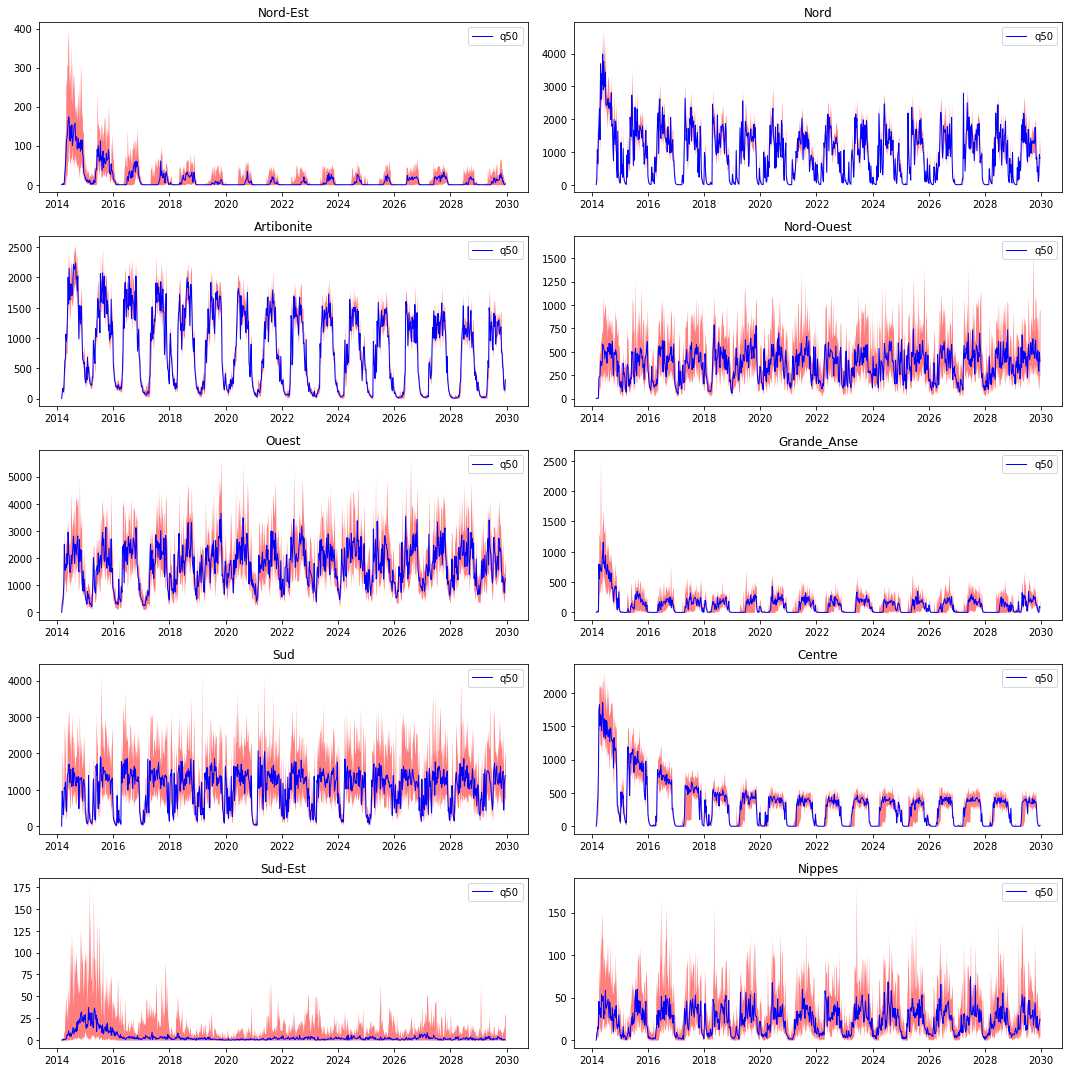

In [6]:
fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, dp in enumerate(dept_avail):
    axes[i].fill_between(all_data[dp]['cases']['q05'].index, all_data[dp]['cases']['q05'], all_data[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    #axes[i].plot(all_data[dp]['cases']['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(dp)
    axes[i].legend()
    
fig.tight_layout()

In [ ]:
       sigma        betaB         mu_B      XthetaA       thetaI       gammaI 
7.082489e-01 1.253227e-01 1.866435e+03 8.358122e-01 2.526162e-03 7.305000e+01 
      lambda      lambdaR            r         rhoA        XrhoI        std_W 
0.000000e+00 8.589310e-01 7.704100e-01 6.792429e+00 6.212963e-03 5.800537e-03 
     epsilon            k      foi_add       Rtot_0       gammaA            H 
9.705881e-01 1.609168e+02 1.092846e-04 4.618106e-02 1.076394e+02 1.727524e+06 
           D           mu        alpha       gammaA          I_0          A_0 
3.530000e+02 1.586626e-02 1.461000e+00 1.076394e+02 1.157726e-06 1.736589e-06 
         B_0        RI1_0        RI2_0        RI3_0        RA1_0        RA2_0 
0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 
       RA3_0 
0.000000e+00 





In [ ]:
fig, axes = plt.subplots((len(compartments))//2, 2, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(result[comp]['q05'].index, result[comp]['q05'], result[comp]['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(result[comp]['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(result[comp]['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    
fig.tight_layout()

In [ ]:
all_param

In [ ]:
all_params